#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>ElasticNet</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

Загрузим необходимые библиотеки и сделаем предварительные настройки

In [4]:
import numpy as np
import pandas as pd
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb.LGBMClassifier
from catboost import CatBoostClassifier
import catboost

pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")

state = 32

print('Setup complete')

Setup complete


Теперь загрузим и изучим данные.

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
def get_info(df):
    display(df.head(), df.info(), df.describe(include = 'all').T)
    print('Процент пропусков:\n', df.isna().mean().sort_values(ascending=False)*100)

In [4]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


None

,count,mean,std,min,25%,50%,75%,max
num_orders,"26,496.0000",14.0705,9.2113,0.0000,8.0000,13.0000,19.0000,119.0000


Процент пропусков:
 num_orders   0.0000
dtype: float64


И так, данные загружены. В нашей выборке имеется времменой промежуток с 01 марта 2018 по 31 августа 2018 и записи кол-ва заказов с интервалом в 10 минут. Отсутвуют пропуски. Максимальное кол-во заказов 119, иногда заказов не было.   

Ресемплируем данные по одному часу. Значения просуммируем, так как нам нужно кол-во заказов за один час.

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь можно приступать к анализу данных.

## Анализ

Наш анализ будет нацелен на то, что бы выявить зависимости кол-ва заказов от временных признаков.   
Для начала убедимся, в хронологическом ли порядке расположены даты и время.

In [6]:
print(df.index.is_monotonic)

True


Добавим среднее и стандартное скользящие с окном 24.    
Посмотрим на график

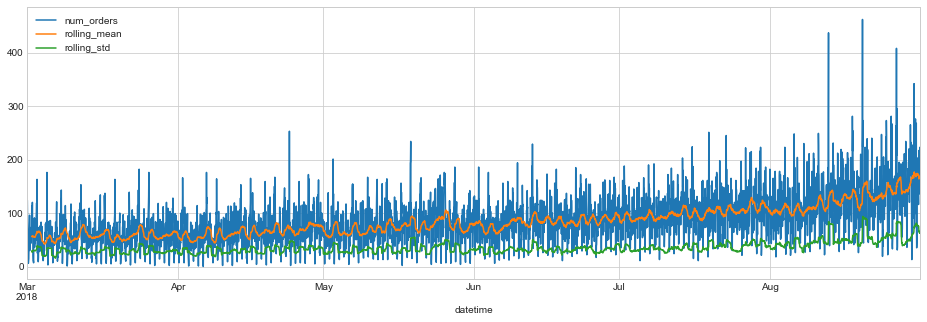

In [7]:
df_new = df.copy()
df_new["rolling_mean"] = df_new["num_orders"].rolling(24).mean()
df_new["rolling_std"] = df_new["num_orders"].rolling(24).std()
df_new.plot(figsize=(16,5));

Изначально выборка достаточно стационарна, посмотрим сильно ли измениться ситуация, если получить разность ряда.

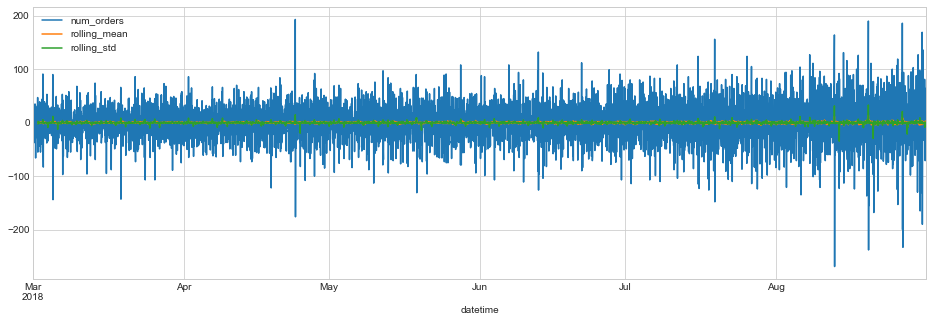

In [8]:
df_shifted = df_new - df_new.shift()
df_shifted.plot(figsize=(16,5));

Видим что выборка стационарна и то что имеется небольшой восходящий тренд.   
Посмотрим графики тренда и сезонности.

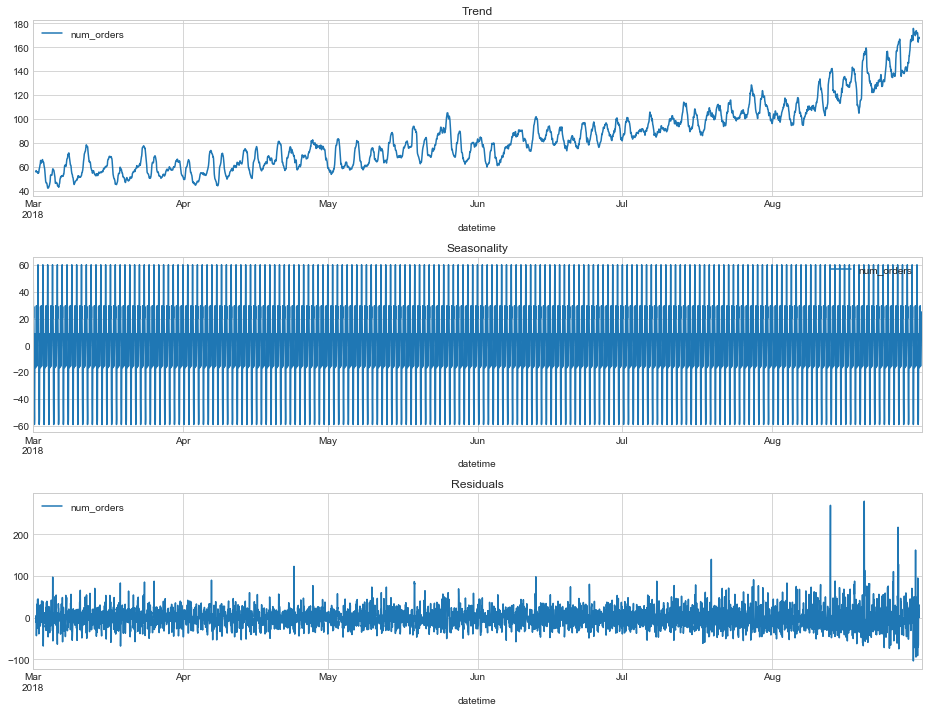

In [9]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(13, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Здесь точно можно сказать что присутсвует тренд на увеличение числа заказов и такж присутсвует сезонность.    
Посмотрим на сезонность поближе

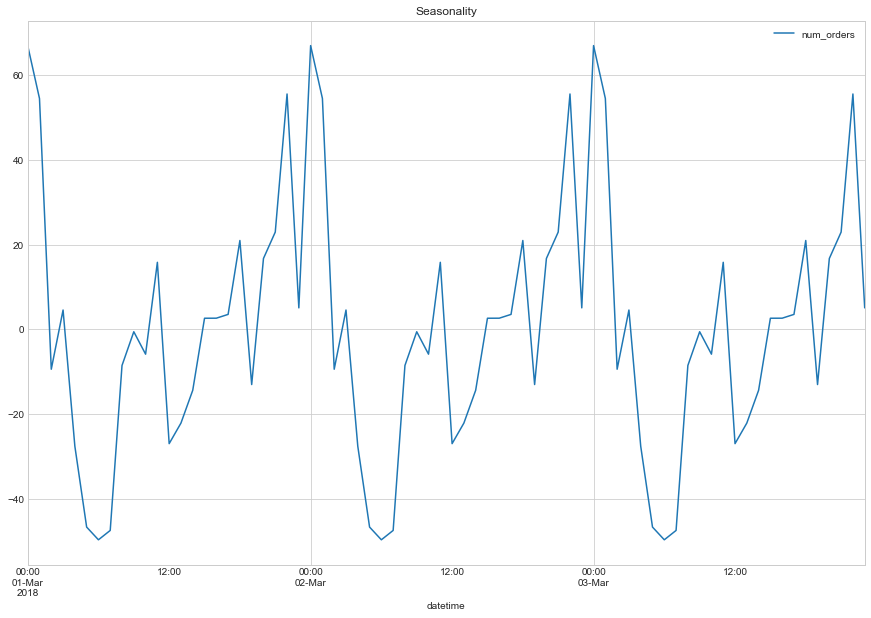

In [10]:
decomposed_day = seasonal_decompose(df['2018-03-01':'2018-03-03'])
decomposed_day.seasonal.plot(figsize=(15, 10))
plt.title('Seasonality');

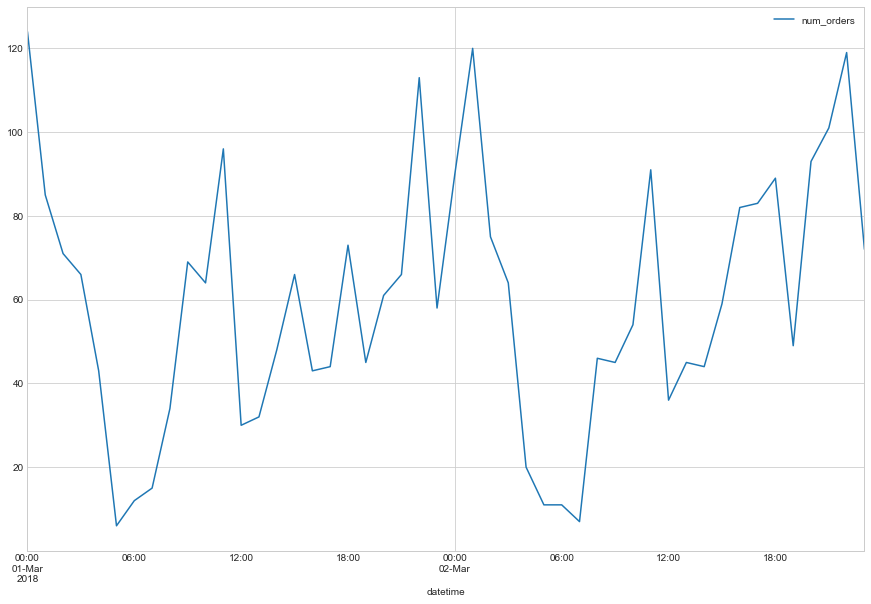

In [11]:
df['2018-03-01':'2018-03-02'].plot(figsize=(15, 10));

Здесь видно что к 6 утра кол-во заказов снижается и возрастает примерно до 10 утра, далее следует спад к обеду и постепенно до 12-1 ночи возрастает.    

Посмотрим как выглядят на графиках 3 разных недели.

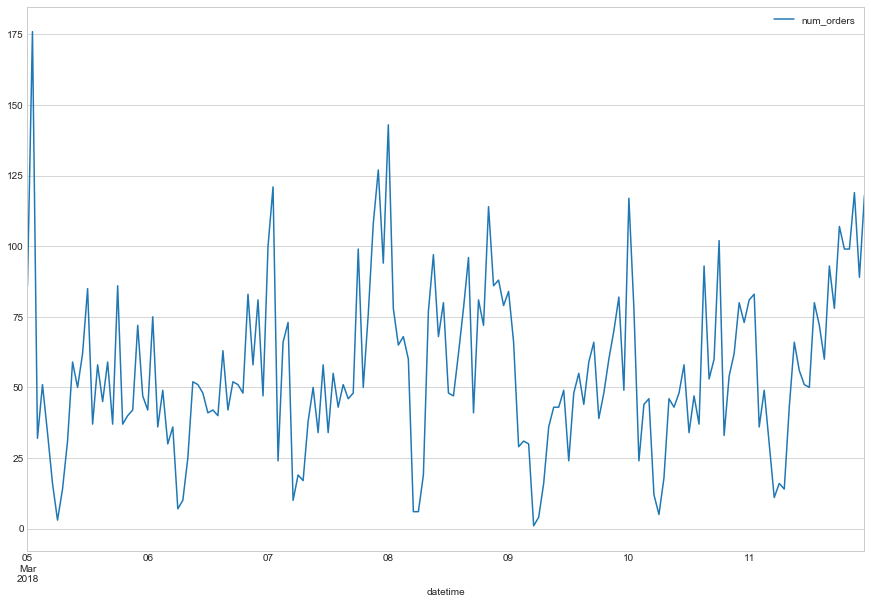

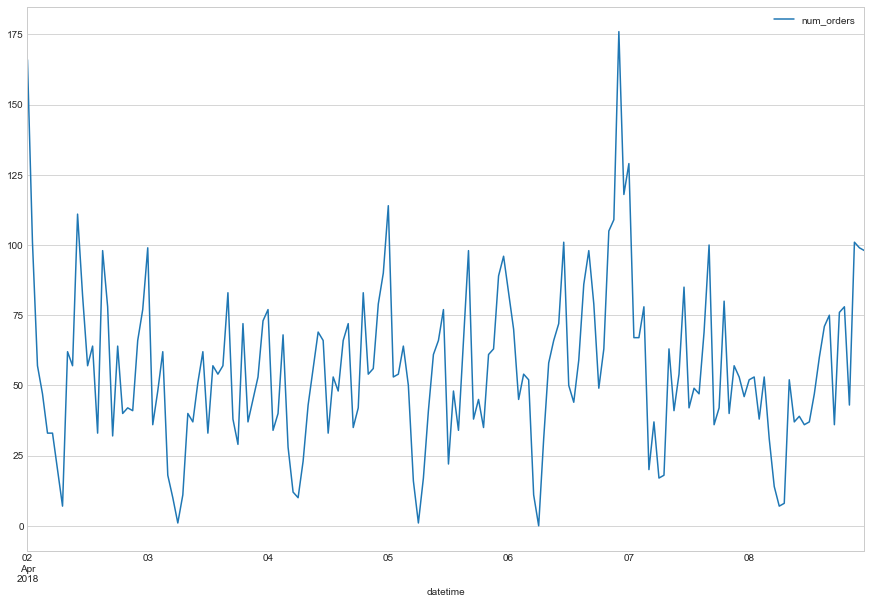

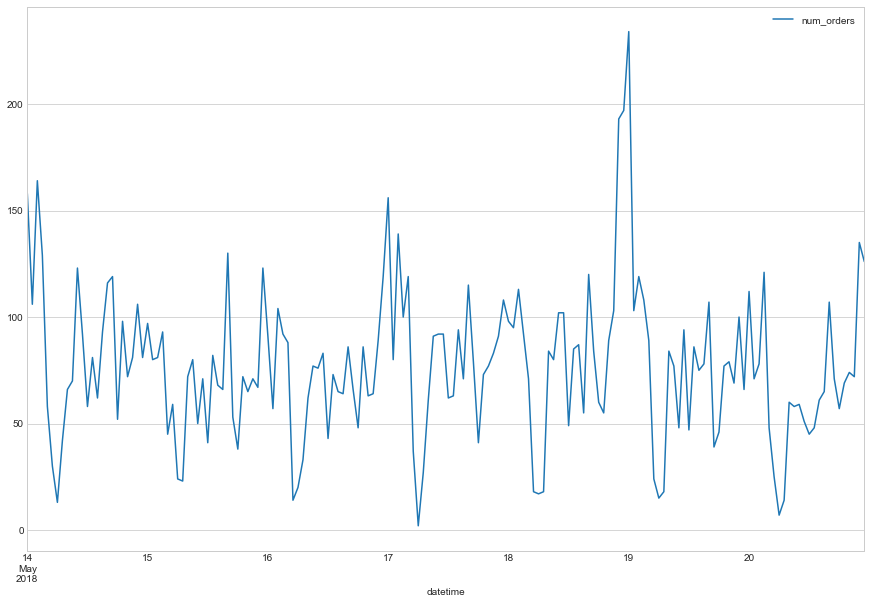

In [12]:
df['2018-03-05':'2018-03-11'].plot(figsize=(15, 10));
df['2018-04-02':'2018-04-08'].plot(figsize=(15, 10));
df['2018-05-14':'2018-05-20'].plot(figsize=(15, 10));

Здесь мы видим что есть некоторое увеличение числа заказов в ночь с понедельника на воскресенье и в ночь с пятницы на субботу.

После нашего исследования можно добавлять новые признаки. Напишем для этого функцию.

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    '''The function will add time features'''
    # std features
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # We'll try to add new features after EDA
    df['is_morning'] = df['hour'].apply(lambda x: 1 if 5 < x < 7 else 0)
    df['is_night'] = df['hour'].apply(lambda x: 1 if x in [0, 23] else 0)
    df['is_saturday'] = df['dayofweek'].apply(lambda x: 1 if x == 5 else 0)
    df['is_monday'] = df['dayofweek'].apply(lambda x: 1 if x == 0 else 0)
    
    # lag features
    for lag in range(1, max_lag + 1):
        df['lag_' + str(lag)] = df['num_orders'].shift(lag)
    
    # rolling mean features
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(df, 20, 10)
df.head()

,num_orders,month,day,dayofweek,hour,is_morning,is_night,is_saturday,is_monday,lag_1,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0,1,0,0,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 01:00:00,85,3,1,3,1,0,0,0,0,124.0000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 02:00:00,71,3,1,3,2,0,0,0,0,85.0000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 03:00:00,66,3,1,3,3,0,0,0,0,71.0000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 04:00:00,43,3,1,3,4,0,0,0,0,66.0000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Признаки подготовлены. Разделим наш датасет на выборки.

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train.shape, test.shape

((3954, 30), (442, 30))

Отдельно создадим выборку для модели LGBMRegressor

In [16]:
train_light = train.astype({"month":'category',
                                  "day":'category',
                                  "dayofweek":'category',
                                  "hour":'category',
                                  "is_morning":'category',
                                  "is_night":'category', 
                            "is_saturday":'category', 
                            "is_monday":'category'})

test_light = test.astype({"month":'category',
                                  "day":'category',
                                  "dayofweek":'category',
                                  "hour":'category',
                                  "is_morning":'category',
                                  "is_night":'category', 
                            "is_saturday":'category', 
                            "is_monday":'category'})

Выделим целевой признак

In [17]:
def split_target(df, target):
    X_df, y_df = df.drop(target, axis=1), df[target]
    return X_df, y_df

X_train, y_train = split_target(train, 'num_orders')
X_test, y_test = split_target(test, 'num_orders')

X_train_light, y_train_light = split_target(train_light, 'num_orders')
X_test_light, y_test_light = split_target(test_light, 'num_orders')


Приступим к обучению моделей

## Обучение

Всего будем сравнивать 5 моделей:
1. LinearRegression
2. ElasticNet
3. RandomForestRegressor
4. CatBoostRegressor
5. LGBMRegressor

Создадим нашу метрику RMSE

In [18]:
def make_rmse(y, y_pred):
    rmse = mean_squared_error(y, y_pred)**0.5
    return rmse

rmse = make_scorer(make_rmse, greater_is_better=False)

Все результаты будем записывать в списки из кторых потом сделаем таблицу

In [19]:
models = []
scores_test = []
scores_train = []

Проверять будем модели кросс-валидацией с подбором параметров GridSearchCV.   
Для разделения будем использовать `TimeSeriesSplit` 

In [20]:
splits = TimeSeriesSplit(n_splits=5)

### LinearRegression

Запишем параметры

In [21]:
lr_params = {'normalize': [True, False],
           'copy_X': [True, False],
           'fit_intercept': [True, False]}
lr_model = LinearRegression()
grid_lr = GridSearchCV(lr_model, lr_params, scoring=rmse, cv=splits)

Подберём параметры кросс-валидацией

In [22]:
%%time
grid_lr.fit(X_train, y_train)

Wall time: 259 ms


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(make_rmse, greater_is_better=False),
             verbose=0)

In [23]:
print('RMSE на обучающей выборке', abs(round(grid_lr.best_score_, 2)))

RMSE на обучающей выборке 28.28


In [24]:
lr_model = grid_lr.best_estimator_
grid_lr.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Запишем результаты

In [25]:
models.append('LinearRegression')
scores_train.append(abs(round(grid_lr.best_score_, 2)))

###  ElasticNet

Запишем параметры

In [26]:
en_params = {'normalize': [True, False],
           'copy_X': [True, False],
           'fit_intercept': [True, False],
            'l1_ratio': [.1, .5, .9],
            'selection': ['cyclic', 'random']}
en_model = ElasticNet(random_state=state)
grid_en = GridSearchCV(en_model, en_params, scoring=rmse, cv=splits)

Подберём параметры кросс-валидацией

In [27]:
%%time
grid_en.fit(X_train, y_train)

Wall time: 7.02 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=32, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'l1_ratio': [0.1, 0.5, 0.9],
                         'normalize': [True, False],
                         'selection': ['cyclic', 'random']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(make_rmse, greater_is_better=False),
             verbose=0)

In [28]:
print('RMSE на обучающей выборке', abs(round(grid_en.best_score_, 2)))

RMSE на обучающей выборке 30.74


In [29]:
en_model = grid_en.best_estimator_
grid_en.best_estimator_

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=False, l1_ratio=0.9,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=32, selection='cyclic', tol=0.0001, warm_start=False)

Запишем результаты

In [30]:
models.append('ElasticNet')
scores_train.append(abs(round(grid_en.best_score_, 2)))

### RandomForestRegressor

Запишем параметры

In [31]:
rf_params = {'max_depth': range(13,25,2),
           'n_estimators': range(60,100,10)}
rf_model = RandomForestRegressor(random_state=state)
grid_rf = GridSearchCV(rf_model, rf_params, scoring=rmse, cv=splits, verbose=1, n_jobs=-1)

Подберём параметры кросс-валидацией

In [32]:
%%time
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   22.4s finished


Wall time: 26.1 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=32,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,


In [33]:
print('RMSE на обучающей выборке', abs(round(grid_rf.best_score_, 2)))

RMSE на обучающей выборке 25.11


In [34]:
rf_model = grid_rf.best_estimator_
grid_rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=32, verbose=0,
                      warm_start=False)

Запишем результаты

In [35]:
models.append('RandomForestRegressor')
scores_train.append(abs(round(grid_rf.best_score_, 2)))

### CatBoostRegressor

Запишем параметры

In [36]:
cat_features = ['month', 'day', 'dayofweek', 'hour', 'is_morning', 'is_night', 'is_saturday', 'is_monday']
cat_params = {'learning_rate': [0.1, 0.5, 1]}

cat_model = CatBoostRegressor(random_state=state, loss_function='RMSE', verbose=0, cat_features=cat_features)
grid_cat = GridSearchCV(cat_model, cat_params, scoring=rmse, cv=splits)

Подберём параметры кросс-валидацией

In [37]:
%%time
grid_cat.fit(X_train, y_train)

Wall time: 8min 3s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x000001FBE92D31C8>,
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(make_rmse, greater_is_better=False),
             verbose=0)

In [38]:
print('RMSE на обучающей выборке', abs(round(grid_cat.best_score_, 2)))

RMSE на обучающей выборке 25.75


In [39]:
cat_model = grid_cat.best_estimator_
grid_cat.best_estimator_

Запишем результаты

In [40]:
models.append('CatBoostRegressor')
scores_train.append(abs(round(grid_cat.best_score_, 2)))

### LGBMRegressor

Запишем параметры

In [41]:
gbm_params = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': range(100,220,10)
}

gbm_model = lgb.LGBMRegressor(random_state=state)

grid_gbm = GridSearchCV(gbm_model, gbm_params, scoring=rmse, cv=splits)

Подберём параметры кросс-валидацией

In [42]:
%%time
grid_gbm.fit(X_train_light, y_train_light)

Wall time: 36 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=32,
                                     reg_alpha=0.0, reg_lambda=0.0,
                                     silent='warn', subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 1],
               

In [43]:
print('RMSE на обучающей выборке', abs(round(grid_gbm.best_score_, 2)))

RMSE на обучающей выборке 26.78


In [44]:
gbm_model = grid_gbm.best_estimator_
grid_gbm.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=32, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Запишем результаты

In [45]:
models.append('LGBMRegressor')
scores_train.append(abs(round(grid_gbm.best_score_, 2)))

Посмотрим, какие признаки для нас играют большую роль.

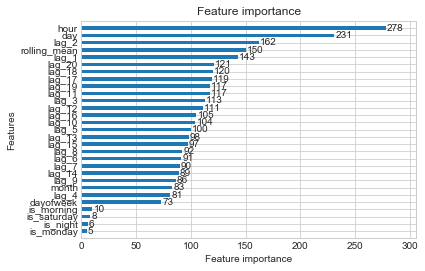

In [46]:
lgb.plot_importance(gbm_model, height=.5);

Категориальные признаки, котрые мы добавляли не играют практически никакой роли. Важнее всего для данной модели у нас оказался час и день.

Параметры подобраны, приступим к тестированию моделей

## Тестирование

Теперь посмотрим результаты RMSE наших моделей на тестовой выборке.   
У нас обучено 5 моделей, котрые сохранены в переменных: `lr_model`, `en_model`, `rf_model`, `cat_model`, `gbm_model`.

In [47]:
# LinearRegression
print('Модель "LinearRegression" RMSE на тестовой выборке', round(make_rmse(y_test, lr_model.predict(X_test)), 2))
scores_test.append(round(make_rmse(y_test, lr_model.predict(X_test)), 2))

# ElasticNet
print('Модель "ElasticNet" RMSE на тестовой выборке', round(make_rmse(y_test, en_model.predict(X_test)), 2))
scores_test.append(round(make_rmse(y_test, en_model.predict(X_test)), 2))

# RandomForestRegressor
print('Модель "RandomForestRegressor" RMSE на тестовой выборке', round(make_rmse(y_test, rf_model.predict(X_test)), 2))
scores_test.append(round(make_rmse(y_test, rf_model.predict(X_test)), 2))

# CatBoostRegressor
print('Модель "CatBoostRegressor" RMSE на тестовой выборке', round(make_rmse(y_test, cat_model.predict(X_test)), 2))
scores_test.append(round(make_rmse(y_test, cat_model.predict(X_test)), 2))

# LGBMRegressor
print('Модель "LGBMRegressor" RMSE на тестовой выборке', round(make_rmse(y_test_light, gbm_model.predict(X_test_light)), 2))
scores_test.append(round(make_rmse(y_test_light, gbm_model.predict(X_test_light)), 2))


Модель "LinearRegression" RMSE на тестовой выборке 50.69
Модель "ElasticNet" RMSE на тестовой выборке 51.85
Модель "RandomForestRegressor" RMSE на тестовой выборке 44.28
Модель "CatBoostRegressor" RMSE на тестовой выборке 39.77
Модель "LGBMRegressor" RMSE на тестовой выборке 40.93


Сделаем так же предсказания моделью, которая предсказывает только медианное значение

In [48]:
pred_median = np.ones(y_test.shape) * train['num_orders'].median()

In [49]:
# Median values
print('Модель "Median values" RMSE на тестовой выборке', round(make_rmse(y_test, pred_median), 2))
models.append('Median values')
scores_test.append(round(make_rmse(y_test, pred_median), 2))
scores_train.append('median_value')

Модель "Median values" RMSE на тестовой выборке 87.15


Теперь посмотрим какие покажет результаты модель, предсказывающая предыдущие значения

In [50]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

In [51]:
# Previous values
print('Модель "Previous values" RMSE на тестовой выборке', round(make_rmse(y_test, pred_previous), 2))
models.append('Previous values')
scores_test.append(round(make_rmse(y_test, pred_previous), 2))
scores_train.append('previous_value')

Модель "Previous values" RMSE на тестовой выборке 58.86


## Общий вывод

Посмотрим теперь на результаты в нашей таблице

In [59]:
report = pd.DataFrame({'train_RMSE_score': scores_train, 'test_RMSE_score': scores_test}, index=models)
report.sort_values(by='test_RMSE_score')

,train_RMSE_score,test_RMSE_score
CatBoostRegressor,25.75,39.77
LGBMRegressor,26.78,40.93
RandomForestRegressor,25.11,44.28
LinearRegression,28.28,50.69
ElasticNet,30.74,51.85
Previous values,previous_value,58.86
Median values,median_value,87.15


Мы подготовили и проанализировали данные. Были выявлены небольшие зависимости кол-ва заказов такси от времени суток и дня недели, но для обучения моделей эти признаки большой роли не сыграли.   
Всего было обучено 5 моделей. Лучший результат на обучающей выборке показал **RandomForestRegressor** со значением RMSE 25.11. На тестовой выборки лучший результат показала модель **CatBoostRegressor** - 39.77, но время обучения больше чем у остальных (более 8 минут). На втором месте по значению RMSE на тестовой выборке **LGBMRegressor** - 40.93. Лучшей из разобранных в данном исследовании моделей выбираем **LGBMRegressor**.